In [ ]:
%pip install langchain==0.3.25 
%pip install langchain-core==0.3.65 
%pip install langchain-openai==0.3.24 
%pip install chromadb==0.6.3 
%pip install langchain-community==0.3.20
%pip install pypdf==5.4.0
%pip install matplotlib
%pip install yfinance

In [1]:
import sys
import yfinance as yf              # Used for gathering stock prices
import matplotlib.pyplot as plt    # Used for Data Visualization / Plots / Graphs
import pandas as pd                # Helpful for working with tabular data like DataFrames
import os                          # Interacting with the operating system

from langchain.text_splitter import RecursiveCharacterTextSplitter      #  Helpful in splitting the PDF into smaller chunks

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader     # Loading a PDF
from langchain_community.vectorstores import Chroma    # Vector DataBase


c:\Users\Karthik Sekhar\Code\Python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]

In [4]:
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o-mini",
    max_tokens=5000,
    temperature=0,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

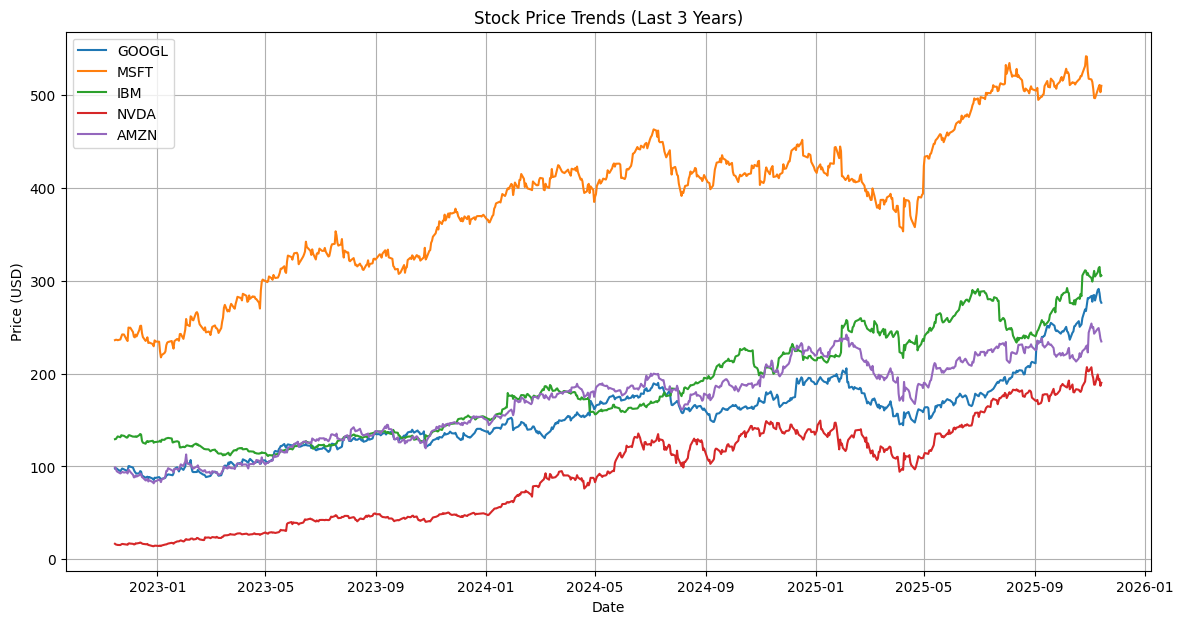

In [6]:
plt.figure(figsize=(14,7))

# Loop through each company and plot closing prices
for symbol in companies:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="3y")  # Last 3 years of data

    # Plot closing price
    plt.plot(data.index, data['Close'], label=symbol)

plt.title("Stock Price Trends (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig("Stock_Price_Trends_3Y.png")
plt.show()

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]
metrics_list = {}

# Fetching the financial metrics
for symbol in companies:                          # Loop through all the companies
    ticker = yf.Ticker(symbol)
    info = ticker.info
    metrics_list[symbol] = {                              # Define the dictionary of all the Finanical Metrics
        "Market Cap": info.get("marketCap", 0),
        "P/E Ratio": info.get("trailingPE", 0),
        "Dividend Yield": info.get("dividendRate", 0),
        "Beta": info.get("beta", 0),
        "Total Revenue": info.get("totalRevenue", 0)
    }

In [8]:
df = pd.DataFrame.from_dict(metrics_list, orient='index')
# Converting large numbers to billions for readability by divinding the whole column by 1e9
df["Market Cap"] =  df["Market Cap"] / 1e9
df["Total Revenue"] = df["Total Revenue"] / 1e9
df["Dividend Yield"] = df["Dividend Yield"] * 100  # Convert to percentage

df   # Printing the df

,Market Cap,P/E Ratio,Dividend Yield,Beta,Total Revenue
GOOGL,3364.478255,27.313242,84.0,1.082,385.476002
MSFT,3791.850570,36.234375,364.0,1.065,293.812011
IBM,285.739221,36.478520,672.0,0.688,65.401999
NVDA,4630.069117,54.025566,4.0,2.269,165.217993
AMZN,2539.781358,33.101550,0.0,1.368,691.330023


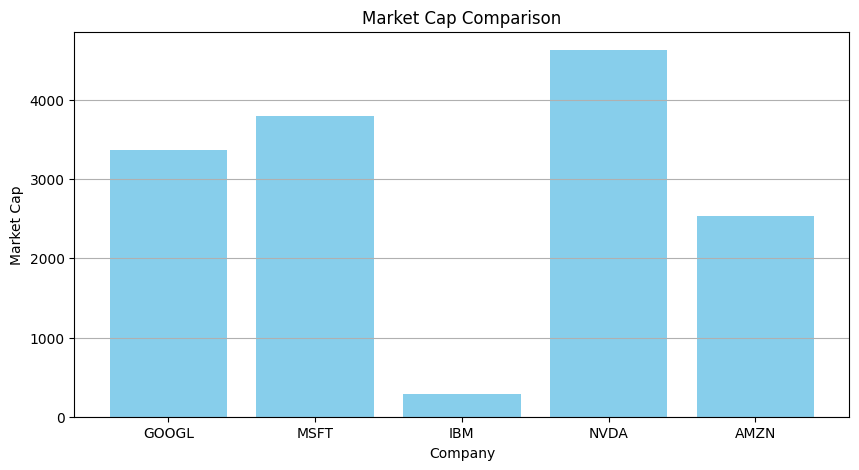

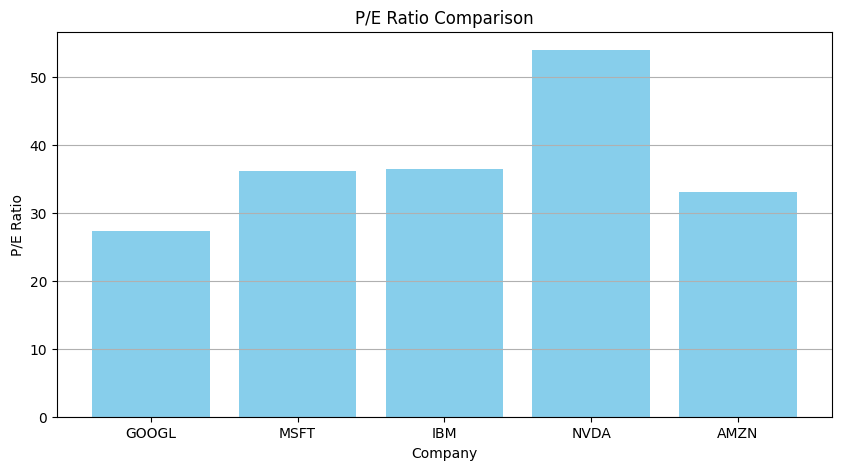

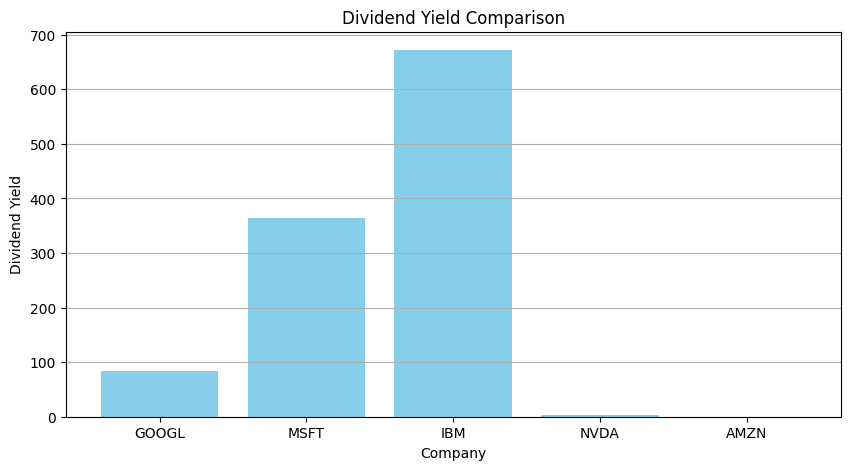

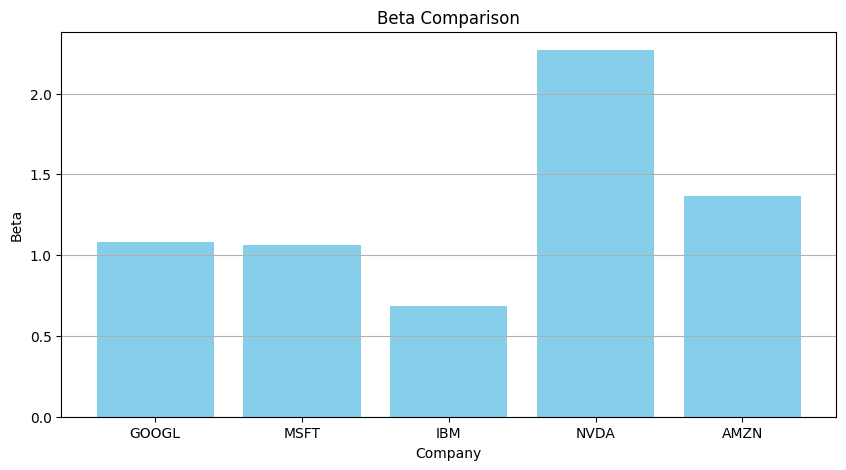

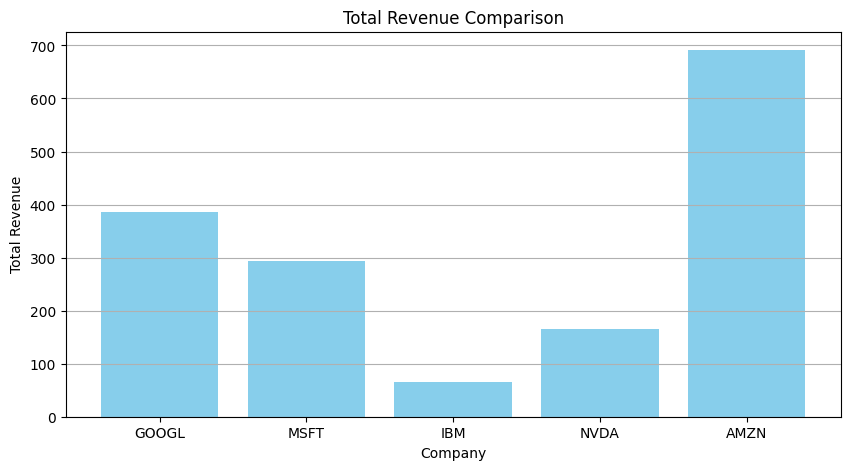

In [9]:
# Plot each metric as a separate bar graph
metrics_to_plot = ["Market Cap", "P/E Ratio", "Dividend Yield", "Beta", "Total Revenue"]

for metric in metrics_to_plot:
    plt.figure(figsize=(10,5))
    plt.bar(df.index, df[metric], color='skyblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Company")
    plt.grid(axis='y')
    plt.show()

In [10]:
# Unzipping the AI Initiatives Documents
import zipfile
with zipfile.ZipFile("Companies-AI-Initiatives.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")  

In [11]:
# Path of all AI Initiative Documents
ai_initiative_pdf_paths = [f"/content/Companies-AI-Initiatives/{file}" for file in os.listdir("/content/Companies-AI-Initiatives")]
ai_initiative_pdf_paths

['/content/Companies-AI-Initiatives/AMZN.pdf',
 '/content/Companies-AI-Initiatives/GOOGL.pdf',
 '/content/Companies-AI-Initiatives/IBM.pdf',
 '/content/Companies-AI-Initiatives/MSFT.pdf',
 '/content/Companies-AI-Initiatives/NVDA.pdf']

In [12]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(path = "/content/Companies-AI-Initiatives/")          # Creating an PDF loader object

In [13]:
# Defining the text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=1000, # Setting chunk size to 1000 tokens
    chunk_overlap=50 #10-20% chunk size
)

In [14]:
# Splitting the chunks using the text splitter
ai_initiative_chunks = loader.load_and_split(text_splitter)
len(ai_initiative_chunks)

62

In [15]:
# Defining the 'text-embedding-ada-002' as the embedding model
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

In [16]:
#  Creating a Vectorstore, storing all the above created chunks using an embedding model
vectorstore = Chroma.from_documents(
    ai_initiative_chunks,
    embedding_model,
    collection_name="AI_Initiatives"
)
    

In [17]:
# Creating an retriever object which can fetch ten similar results from the vectorstore
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

In [18]:
user_message = "Give me the best project that `IBM` company is working upon"
# Building the context for the query using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(user_message)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)
len(relevant_document_chunks)

C:\Users\Karthik Sekhar\AppData\Local\Temp\ipykernel_18488\2586574799.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_document_chunks = retriever.get_relevant_documents(user_message)


10

In [20]:
qna_system_message = """You are a highly intelligent AI assistant that helps people find information about various AI initiatives undertaken by top tech companies. Use the context provided to answer the user's question accurately and concisely. If the context does not contain the answer, respond with "I don't know."""

In [21]:
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

In [22]:
# Format the prompt
formatted_prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_message)}
                [/INST]"""


In [23]:
# Make the LLM call
resp = llm.invoke(formatted_prompt)
resp.content

"The best project that IBM is currently working on is the Granite initiative. It involves a series of open-source, high-performance AI foundation models designed to empower enterprise applications across various industries. Launched in September 2023, Granite models are customizable and scalable, enabling businesses to integrate advanced AI capabilities into their workflows while maintaining control over their data. This initiative aligns with IBM's strategic focus on providing efficient and responsible enterprise-grade AI solutions."

In [24]:
# Define RAG function
def RAG(user_message):
    """
    Args:
    user_message: Takes a user input for which the response should be retrieved from the vectorDB.
    Returns:
    relevant context as per user query.
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_message)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)
    # Combine qna_system_message and qna_user_message_template to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context= context_for_query, question=user_message)}
                [/INST]"""
    
    # Quering the LLM
    try:
        response = llm.invoke(prompt)

    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response.content

In [ ]:
# Test Cases
print(RAG("How is the area in which GOOGL is working different from the area in which MSFT is working?"))
print(RAG("What is the timeline of each project in NVDA?"))

In [28]:
# Writing a question for performing evaluations on the RAG
evaluation_test_question = "What are the three projects on which MSFT is working upon?"
# Building the context for the evaluation test question using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(evaluation_test_question)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)
# Default RAG Answer
answer = RAG(evaluation_test_question)
print(answer)

Microsoft is working on the following three projects:

1. **Azure AI Foundry Labs**: An experimental AI platform designed to accelerate the translation of advanced AI research into real-world applications, supporting experimentation with various AI technologies.

2. **Microsoft 365 Copilot**: An AI-powered productivity assistant integrated across Microsoft 365 applications that enhances productivity by automating tasks and providing intelligent assistance.

3. **GitHub Copilot & IntelliCode**: GitHub Copilot is an AI coding assistant that suggests code completions and reviews pull requests, while IntelliCode offers context-aware suggestions within Visual Studio and Visual Studio Code to improve developer productivity.


In [29]:
# Defining user messsage template for evaluation
evaluation_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [30]:
# Writing the system message and the evaluation metrics for checking the groundedness
groundedness_rater_system_message = """You are an expert evaluator that rates the groundedness of answers provided by an AI system based on the context given. Your task is to determine how well the answer is supported by the context. Rate the groundedness on a scale from 1 to 5, where 1 means "Not Grounded" (the answer is not supported by the context at all) and 5 means "Fully Grounded" (the answer is completely supported by the context). Provide a brief explanation for your rating."""

In [31]:
# Combining groundedness_rater_system_message + llm_prompt + answer for evaluation
groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""

In [32]:
# Defining a new LLM object
groundness_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Groundedness
groundness_response = groundness_checker.invoke(groundedness_prompt)
print(groundness_response.content)

**Rating: 5 - Fully Grounded**

The answer is fully grounded as it accurately lists and describes the three projects Microsoft is working on, which are explicitly detailed in the provided context. Each project—Azure AI Foundry Labs, Microsoft 365 Copilot, and GitHub Copilot & IntelliCode—is mentioned along with a brief summary of its purpose and functionality. The descriptions align perfectly with the information given in the context about Microsoft's initiatives in AI development and productivity enhancement. Therefore, there is strong support for each part of the answer based on the context provided.


In [33]:
# Writing the system message and the evaluation metrics for checking the relevance
relevance_rater_system_message = """You are an expert evaluator that rates the relevance of answers provided by an AI system based on the question asked. Your task is to determine how well the answer addresses the question. Rate the relevance on a scale from 1 to 5, where 1 means "Not Relevant" (the answer does not address the question at all) and 5 means "Highly Relevant" (the answer directly and comprehensively addresses the question). Provide a brief explanation for your rating."""

# Combining relevance_rater_system_message + llm_prompt + answer for evaluation
relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""

# Defining a new LLM object
relevance_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Relevance
relevance_response = relevance_checker.invoke(relevance_prompt)
print(relevance_response.content)

**Rating: 5**

The answer directly and comprehensively addresses the user's question about the three projects Microsoft is working on. It clearly lists each project—Azure AI Foundry Labs, Microsoft 365 Copilot, and GitHub Copilot & IntelliCode—providing a brief summary of what each project entails. This aligns perfectly with the request for information about Microsoft's current initiatives, making it highly relevant.


In [34]:
# Fetching all the links of the documents
len(vectorstore.get()['documents'])

# Write a system message for instructing the LLM for scoring and ranking the companies
system_message = """You are an expert financial analyst. Based on the AI initiatives described in the provided documents, evaluate and rank the companies in terms of their innovation and potential for future growth. Consider factors such as the scope of AI projects, investment in AI research, and the impact of these initiatives on their respective industries. Provide a ranked list of companies along with a brief justification for each ranking."""

# Write a user message for instructing the LLM for scoring and ranking the companies
user_message = f"""###Context
Here are the documents describing various AI initiatives undertaken by top tech companies.  
### 1. Financial Data
{df.to_string()}
---
### 2. AI Initiatives
{vectorstore.get()['documents']}
"""

# Formatting the prompt
formatted_prompt = f"""[INST]{system_message}\n
                {'user'}: {user_message}
                [/INST]"""

# Calling the LLM
recommendation = llm.invoke(formatted_prompt)
recommendation.content

print(recommendation.content)

Based on the AI initiatives described in the provided documents, I have evaluated and ranked the companies according to their innovation and potential for future growth. The ranking considers factors such as the scope of AI projects, investment in AI research, and the impact of these initiatives on their respective industries.

### Ranked List of Companies

1. **Amazon (AMZN)**
   - **Justification**: Amazon's extensive use of AI across its e-commerce platform (product recommendations, dynamic pricing) and cloud services (AWS SageMaker, Bedrock) demonstrates a comprehensive approach to integrating AI into business operations. The launch of Olympus signifies a strong commitment to generative AI capabilities that can enhance user experience significantly. Their ongoing investments in infrastructure for machine learning further solidify their leadership position.
   
2. **Google (GOOGL)**
   - **Justification**: Google has made significant strides with its Gemini initiative which integrat